In [1]:
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
_tokenizer = RegexpTokenizer(r'\w+')

In [2]:
def load_pickle(path, filename):
    with open(path+filename+'.pkl', 'rb') as f:
        file = pickle.load(f)
    return file

def load_file(path, filename):
    with open(path+filename, 'r') as file:
        data = file.read()
    return data

def unseen_samples(train_categories, y):
    c =0
    for i in y:
        if i not in train_categories:
            c += 1
    print('Samples with unseen predicate: ', c)
    
    
def max_accuracy(test_sbj, candidates_test):
    count = 0
    for i in range(len(test_sbj)):
        if test_sbj[i] in candidates_test[i]:
            count += 1
    return count/len(candidates_test)

def mid2pred(path,pred_to_ix):
    mid2predicate = dict()
    with open(file=path,mode='r') as handle:
         for line in handle.readlines():
                spo = line.split('\t')
                s = spo[0].replace("www.freebase.com/m/","")
                p = spo[1].replace("www.freebase.com/","")

                if p in pred_to_ix:
                    if s in mid2predicate:
                        mid2predicate[s] =  mid2predicate[s]+[pred_to_ix[p]]
                    else:
                        mid2predicate[s] = [pred_to_ix[p]]
    
    return mid2predicate

def predicates_per_quest(candidates, mid2pred):
    predicates_per_question = []
    for cand in candidates:
        predicates_per_cand =[mid2pred[i] for i in cand if i in mid2pred]
        predicates_per_cand_flat = [item for sublist in predicates_per_cand for item in sublist]

        predicates_per_question.append(predicates_per_cand_flat)

    return predicates_per_question


def preprocess(string):
    tokens = _tokenizer.tokenize(string)
    tokens = [t.lower() for t in tokens]
    return tokens

In [3]:
path = '../data/explore/RP_no_plc//'
y_train = load_pickle(path=path+'train/',filename='targets')
y_valid = load_pickle(path=path+'valid/',filename='targets')
y_test = load_pickle(path=path+'test/',filename='targets')

# Dataset without entries with missing subject entities
path = '../data/explore/RP/'
train_sbj = load_pickle(path=path+'train/',filename='sbj')
val_sbj = load_pickle(path=path+'valid/',filename='sbj')
test_sbj = load_pickle(path=path+'test/',filename='sbj')

## Dataset statistics

### Entities

In [4]:
print('Unique entities train: ',' total: ', len(set(train_sbj)))
print('Unique entities test: ',len(set(test_sbj).difference(set(train_sbj))), ' total unique: ',len(set(test_sbj)),
      ' total: ', len(test_sbj))
print('Unique entities valid: ',len(set(val_sbj).difference(set(train_sbj))),' total unique: ',len(set(val_sbj)),
      ' total: ', len(val_sbj))

Unique entities train:   total:  63804
Unique entities test:  16966  total unique:  19345  total:  21568
Unique entities valid:  8495  total unique:  9882  total:  10777


In [5]:
unseen_samples(set(train_sbj),val_sbj)

Samples with unseen predicate:  8562


In [6]:
len((set(train_sbj).union(set(test_sbj))).union(set(val_sbj)))

89066

### Relations

In [7]:
counter_com_train = Counter(y_train.flatten()).most_common()
counter_com_test = Counter(y_test.flatten()).most_common()
counter_com_valid = Counter(y_valid.flatten()).most_common()

In [8]:
target_predicates_txt = load_file(path='../data/explore/',filename='targets_all.txt')

In [9]:
target_predicates = set()
for line in  target_predicates_txt.split("\n")[:-1]:
    target_predicates.add(line)
    
predicates = sorted(list(target_predicates))
print("Initialize dataset with {} unique predicates.".format(len(predicates)))
pred_to_ix = { ch:i for i,ch in enumerate(predicates) }
ix_to_pred = { i:ch for i,ch in enumerate(predicates) }

target_names = []
for k,v in pred_to_ix.items():
    target_names.append(k.replace('www.freebase.com/',"")+'('+str(v)+')')

Initialize dataset with 1837 unique predicates.


#### Number of unique predicate classes within domain

In [10]:
domains = [label.split('/')[0] for label in target_names]
print(Counter(domains).most_common())

[('base', 405), ('user', 121), ('music', 82), ('medicine', 66), ('book', 61), ('film', 61), ('fictional_universe', 50), ('cvg', 43), ('sports', 41), ('location', 40), ('education', 38), ('tv', 37), ('computer', 36), ('people', 31), ('geography', 30), ('aviation', 26), ('food', 25), ('theater', 25), ('astronomy', 24), ('biology', 24), ('religion', 24), ('comic_books', 23), ('government', 23), ('architecture', 22), ('broadcast', 22), ('business', 21), ('visual_art', 20), ('amusement_parks', 17), ('award', 16), ('spaceflight', 16), ('time', 16), ('language', 15), ('organization', 15), ('travel', 15), ('digicams', 14), ('internet', 14), ('media_common', 14), ('metropolitan_transit', 14), ('type', 13), ('automotive', 12), ('law', 12), ('american_football', 11), ('chemistry', 11), ('military', 11), ('basketball', 10), ('olympics', 10), ('wine', 10), ('baseball', 8), ('boats', 8), ('games', 8), ('royalty', 8), ('common', 7), ('dining', 7), ('event', 7), ('exhibitions', 7), ('opera', 7), ('pro

#### Unique domains

In [11]:
domains_train = [target_names[label_id].split('/')[0] for label_id in y_train]
domains_valid = [target_names[label_id].split('/')[0] for label_id in y_valid]
domains_test = [target_names[label_id].split('/')[0] for label_id in y_test]

print('domains_train: ', len(set(domains_train)))
print('domains_valid: ', len(set(domains_valid)))
print('domains_test: ', len(set(domains_test)))

domains_train:  82
domains_valid:  68
domains_test:  74


#### Number of samples per domain

In [12]:
print('Domain and number of occurences, train')
print(Counter(domains_train).most_common())

print('Domain and number of occurences, validation')
print(Counter(domains_valid).most_common())

print('Domain and number of occurences, test')
print(Counter(domains_test).most_common())

Domain and number of occurences, train
[('music', 20301), ('people', 12516), ('film', 9405), ('location', 6353), ('book', 4522), ('cvg', 2183), ('medicine', 2015), ('media_common', 1845), ('tv', 1818), ('common', 1813), ('astronomy', 1284), ('base', 1176), ('soccer', 1011), ('education', 937), ('fictional_universe', 836), ('visual_art', 622), ('broadcast', 504), ('time', 468), ('organization', 456), ('baseball', 399), ('military', 357), ('architecture', 344), ('business', 337), ('geography', 335), ('influence', 326), ('sports', 270), ('biology', 252), ('user', 230), ('symbols', 222), ('language', 208), ('american_football', 204), ('computer', 162), ('travel', 154), ('aviation', 145), ('food', 144), ('automotive', 141), ('theater', 137), ('government', 106), ('basketball', 106), ('ice_hockey', 92), ('award', 87), ('type', 86), ('transportation', 84), ('religion', 76), ('martial_arts', 71), ('olympics', 68), ('metropolitan_transit', 66), ('comic_books', 55), ('meteorology', 48), ('period

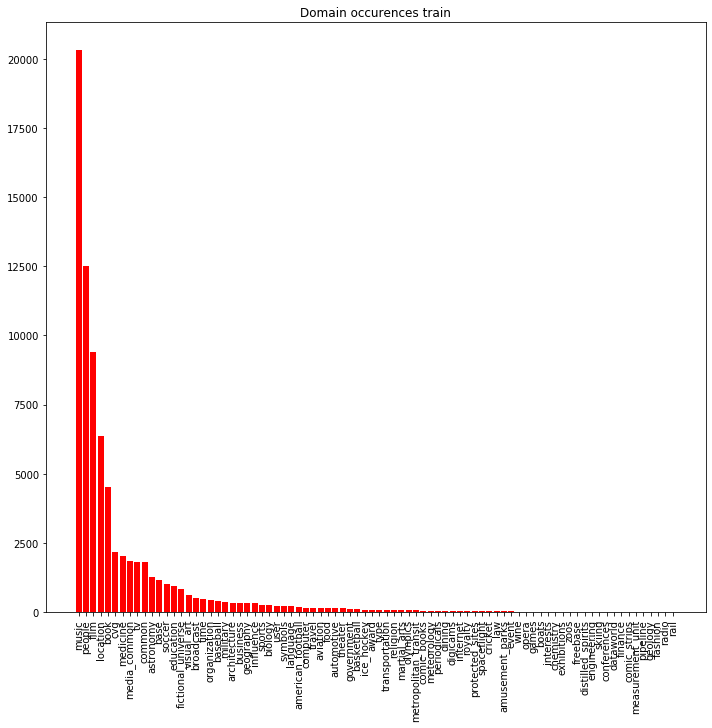

In [13]:
frq = [i[1] for i in Counter(domains_train).most_common()]
word = [i[0] for i in Counter(domains_train).most_common()]

indices = np.arange(len(word))
plt.figure(figsize=(10, 10))
plt.bar(indices, frq, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.title('Domain occurences train')
plt.show()

#### Unique relation classes

In [14]:
for i in [y_train,y_valid,y_test]:
    print('Data len: ', len(i))
    print('Unique categories: ', len(set(i)))

Data len:  75910
Unique categories:  1629
Data len:  10845
Unique categories:  783
Data len:  21687
Unique categories:  1034


#### Unable to obtain entity name mappings for some MID

In [15]:
# missing MIDs 
print('Train no sbj: ', len(y_train)-len(train_sbj))
print('Validation no sbj: ', len(y_valid)-len(val_sbj))
print('Test no sbj: ', len(y_test)-len(test_sbj))

Train no sbj:  421
Validation no sbj:  68
Test no sbj:  119


#### Unseen relation classes and unseen number of samples

In [16]:
train_categories = set(y_train)
print('Valid:')
unseen_samples(train_categories,y_valid)
print('Test:')
unseen_samples(train_categories,y_test)

Valid:
Samples with unseen predicate:  71
Test:
Samples with unseen predicate:  161


In [17]:
print('Unseen relation classes, test: ', len(set(y_test).difference(set(y_train))))
print('Unseen relation classes, valid: ',len(set(y_valid).difference(set(y_train))))

Unseen relation classes, test:  148
Unseen relation classes, valid:  69


## Checking annotations for Mention Detection

Since no gold annotations are provided for the Mention Detection task, we build them ourselves. Below, we check how valid our approach was.

In [18]:
mid2entity = load_pickle(path = '../data/explore/', filename='mid2entities')

In [19]:
test_q = load_pickle('../data/explore/MD/valid/','questions')
test_non = load_pickle('../data/explore/MD/valid/','none_sbj')
test_an = load_pickle('../data/explore/MD/valid/','annotations')
test_sbj= load_pickle('../data/explore/MD/valid/','sbj')
test_obj= load_pickle('../data/explore/MD/valid/','obj')

In [20]:
import difflib


In [21]:
count =0
count_wrong_len = 0
test_q = [v for k,v in enumerate(test_q) if k not in test_non]
test_sbj =  [v for k,v in enumerate(test_sbj) if k not in test_non]
test_obj =  [v for k,v in enumerate(test_obj) if k not in test_non]

for ind in range(len(test_q)):
    indices = [k for k, v in enumerate(test_an[ind]) if v == 1]
    alias = [test_q[ind][i] for i in indices]
    if alias == preprocess(mid2entity[test_sbj[ind]][0] if len(mid2entity[test_sbj[ind]])!=0 else ""):
        count += 1
    else:
        print(alias, ind)
        print(preprocess(mid2entity[test_sbj[ind]][0] if len(mid2entity[test_sbj[ind]])!=0 else ""))
        print(preprocess(mid2entity[test_obj[ind]][0] if len(mid2entity[test_obj[ind]])!=0 else ""),': obj')
        print(test_q[ind])
        print('_______________')
        if len(alias)!=len(preprocess(mid2entity[test_sbj[ind]][0] if len(mid2entity[test_sbj[ind]])!=0 else "")):
            count_wrong_len += 1
            

print(count/len(test_q))
print(count_wrong_len/len(test_q))

['what', 'is', 'the', 'active'] 46
['camphor', 'natural', 'menthol', '2', '100', 'spray']
['menthol'] : obj
['what', 'is', 'the', 'active', 'ingredient', 'moiety', 'in', 'fast', 'freeze']
_______________
['meccas'] 49
['mecca']
['mecca'] : obj
['what', 'is', 'the', 'name', 'for', 'meccas', 'canonical', 'version']
_______________
['featured'] 70
['megan', 'romero']
['female'] : obj
['what', 'track', 'is', 'featured', 'on', 'the', 'salisbury', 'release']
_______________
['what'] 77
['datskat']
['ahmir', 'khalib', 'thompson'] : obj
['what', 'composer', 'created']
_______________
['who', 's', 'a', 'linebacker'] 107
['ron', 'warner']
['linebacker'] : obj
['who', 's', 'a', 'linebacker']
_______________
['assassins', 'creed', 'revelations'] 142
['assassin', 's', 'creed', 'revelations']
['action', 'adventure', 'game'] : obj
['what', 'kind', 'of', 'game', 'is', 'assassins', 'creed', 'revelations']
_______________
['documentary', 'films'] 164
['documentary', 'film']
['an', 'affair', 'of', 'the',

In [22]:
(381+count)/len(test_q)

0.9862670501994989

In [23]:
len(test_q)-count

529